# Algorithmic trading with Keras (using LSTM)

We use a Long Short Time Memory recurrent neural network to develop a good trading strategy: the first trading day of each month we want our model to tell us if we are going to stay in the market for the current month or not.

We verify that, in the COVID period, this LSTM-trading-strategy is far better than the buy and hold strategy (stay always in the market) and the simple moving average strategy (buy when the current price is greater or equal to the moving average of past 12 months and sell otherwise).

We compute the gross and net yield (26% tax on capital gain and 0.10% fee to the broker at each transaction): our model performed roughly a **45.28%** net annual yield.

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## Part 1: Get the data



In [ ]:
start_date=datetime.datetime(2014, 1, 1)
end_date=datetime.datetime(2024, 1,31)

df = yf.download('META', start=start_date, end=end_date)
df.drop("Adj Close", axis=1, inplace=True)
df.to_csv("META.csv")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df=pd.read_csv("META.csv")
df.index=pd.to_datetime(df["Date"])
df=df.drop("Date",axis=1)

In order to develop our trading strategy, we need to obtain a dataframe with the monthly means and the first trading day of the month price. First we obtain the monthly means:

In [ ]:
dfm=df.resample("M").mean()

dfm=dfm[:-1] # As we said, we do not consider the month of end_date

print(dfm.head())
print(dfm.tail())

                 Open       High        Low      Close        Volume
Date                                                                
2014-01-31  56.960952  57.848571  55.997143  56.928095  6.165309e+07
2014-02-28  66.121053  67.216842  65.234211  66.370526  5.846179e+07
2014-03-31  67.727619  68.415238  66.125715  67.093333  5.978286e+07
2014-04-30  59.970000  61.036190  58.259048  59.606667  8.971262e+07
2014-05-31  60.003333  60.990952  59.203810  60.087143  5.334074e+07
                  Open        High         Low       Close        Volume
Date                                                                    
2023-08-31  300.414349  304.236524  295.956087  299.857828  1.839773e+07
2023-09-30  301.227998  305.573500  297.119501  301.118500  2.033433e+07
2023-10-31  310.834094  315.278179  306.353636  310.868636  2.324127e+07
2023-11-30  327.345716  331.389996  324.519521  328.485238  1.567955e+07
2023-12-31  337.416499  341.848001  334.671503  338.946500  1.664069e+07


Then we obtain the list of the first trading day for each month

In [ ]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

<ipython-input-5-072f9201361b>:9: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(start_year)+"-"+str(month)].index))
<ipython-input-5-072f9201361b>:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(year)+"-"+str(month)].index))
<ipython-input-5-072f9201361b>:16: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  first_days.append(min(df[str(end_year)+"-"+str(month)].index))


Now for each month we have the means of the month, the first trading day of the current month (and its open price) and the first trading day of the next month (and its open price).

The feature *rapp* is the quotient between the open price of the first trading day of the next month and the open price of the first trading day of the current month. It will be used because it gives the variation of the portfolio for the current month

In [ ]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [ ]:
print(dfm.head())
print(dfm.tail())

                 Open       High        Low      Close        Volume  \
Date                                                                   
2014-01-31  56.960952  57.848571  55.997143  56.928095  6.165309e+07   
2014-02-28  66.121053  67.216842  65.234211  66.370526  5.846179e+07   
2014-03-31  67.727619  68.415238  66.125715  67.093333  5.978286e+07   
2014-04-30  59.970000  61.036190  58.259048  59.606667  8.971262e+07   
2014-05-31  60.003333  60.990952  59.203810  60.087143  5.334074e+07   

                fd_cm      fd_nm  fd_cm_open  fd_nm_open      rapp  
Date                                                                
2014-01-31 2014-01-02 2014-02-03   54.830002   63.029999  1.149553  
2014-02-28 2014-02-03 2014-03-03   63.029999   66.959999  1.062351  
2014-03-31 2014-03-03 2014-04-01   66.959999   60.459999  0.902927  
2014-04-30 2014-04-01 2014-05-01   60.459999   60.430000  0.999504  
2014-05-31 2014-05-01 2014-06-02   60.430000   63.230000  1.046335  
            

Now we add the columns corresponding to the moving averages at 1 and 2 years

In [ ]:
dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)

Note that in this way each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)

We remove the first 24 months, since they do not have the 2-year moving average

In [ ]:
dfm=dfm.iloc[24:,:] # WARNING: DO IT JUST ONE TIME!
print(dfm.index)

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
      

Finally, we can divide *dfm* in train and test set

In [ ]:
mtest=36
train=dfm.iloc[:-mtest,:]
test=dfm.iloc[-mtest:,:]

## Part 2: Define functions to compute gross and net yield

Notice that the gross yield can be computed very easily using the feature *rapp*.
The following function explains how: the vector v selects which months we are going to stay in the market

In [ ]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

We just need to define a function to compute the net yield, considering (as it is by the Italian law) a 26% tax on capital gain and 0.10% commission to the broker at each transaction

In [ ]:
tax_cg=0.26
comm_bk=0.001

In [ ]:
# This function will be used in the function yield_net

# Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v
# and their number.
# For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
# out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

def expand_islands2D(v):

    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0

    # Initialize 1D id array  of size same as expected o/p and has
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

Again, the vector v selects which months we are going to stay in the market

In [ ]:
# This function returns the total percentage net yield and the annual percentage net yield

def yield_net(df,v):
    n_years=len(v)/12

    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n))

    return (prod-1)*100,((prod**(1/n_years))-1)*100

## Part 3: Define the LSTM model

We want to use a LSTM neural network to decide, the first day of each day of the test period, whether we are going to stay in the market for the month or not.

We reshape the data (the LSTM wants the data in a particular shape, involving "windows") and at each step we want to predict the opening price of the first day of the next month: in this way we will be able to find the vector v which selects the months during which we are going to stay in the market

In [ ]:
def create_window(data, window_size = 1):
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)

    data.dropna(axis=0, inplace=True)
    return(data)

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
dg0=dg[[0,1,2,3,4,5,6,7]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
print(X_dfw.shape)
print(dfw.iloc[:4,:])
print(X_dfw[0,:,:])

y_dfw=np.array(dg[8][window:])

(92, 5, 8)
          0         1         2         3         4         5         6  \
0  0.000000  0.000000  0.000000  0.000000  0.640490  0.026712  0.000000   
1  0.027355  0.026691  0.025617  0.026186  0.680947  0.062890  0.007823   
2  0.041238  0.047747  0.042687  0.044525  0.273446  0.047325  0.018107   
3  0.047030  0.051712  0.048834  0.048879  0.509988  0.068078  0.028569   

          7         0         1  ...         6         7         0         1  \
0  0.000000  0.027355  0.026691  ...  0.028569  0.025159  0.069737  0.078125   
1  0.008505  0.041238  0.047747  ...  0.039108  0.035673  0.058026  0.066294   
2  0.016537  0.047030  0.051712  ...  0.052822  0.047419  0.072950  0.079566   
3  0.025159  0.069737  0.078125  ...  0.064252  0.057632  0.091721  0.101397   

          2         3         4         5         6         7  
0  0.071994  0.073524  0.237350  0.082381  0.039108  0.035673  
1  0.060845  0.061500  0.208092  0.084730  0.052822  0.047419  
2  0.074830  0.07621

In [ ]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

In [ ]:
def model_lstm(window,features):

    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')


    return model

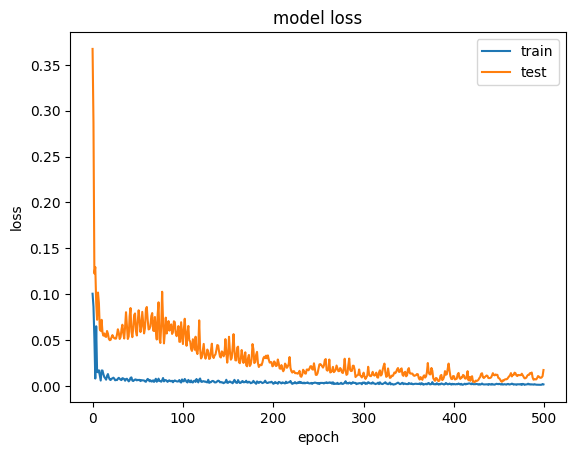

In [ ]:
model=model_lstm(window+1,8)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=0, callbacks=[],shuffle=False)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
y_pr=model.predict(X_trainw)

2/2 [==============================] - 1s 17ms/step


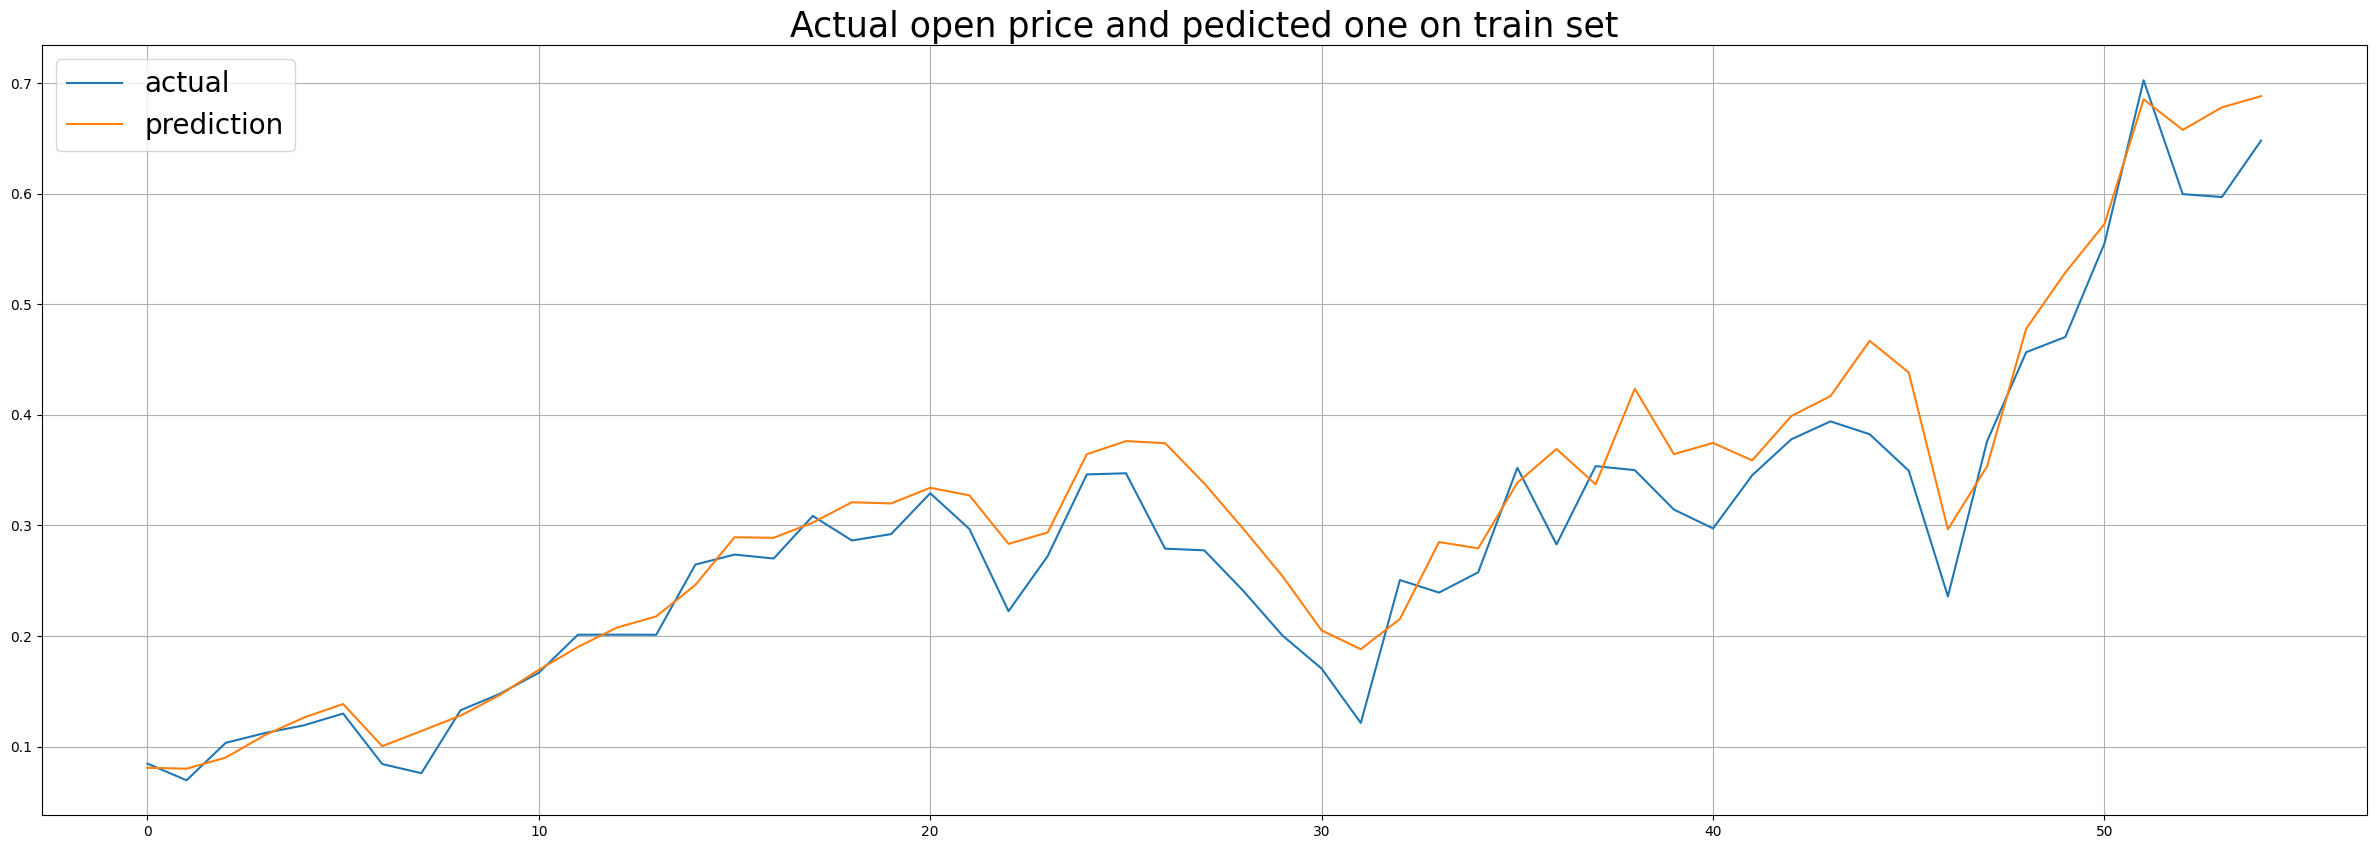

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [ ]:
y_pred=model.predict(X_testw)

2/2 [==============================] - 0s 10ms/step


**We stay in the market when the predicted price for the next month is greater than the current price and stay out otherwise. The vector v indicates the "in months" (as 1s) and "out months" (as 0s)**

In [ ]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)

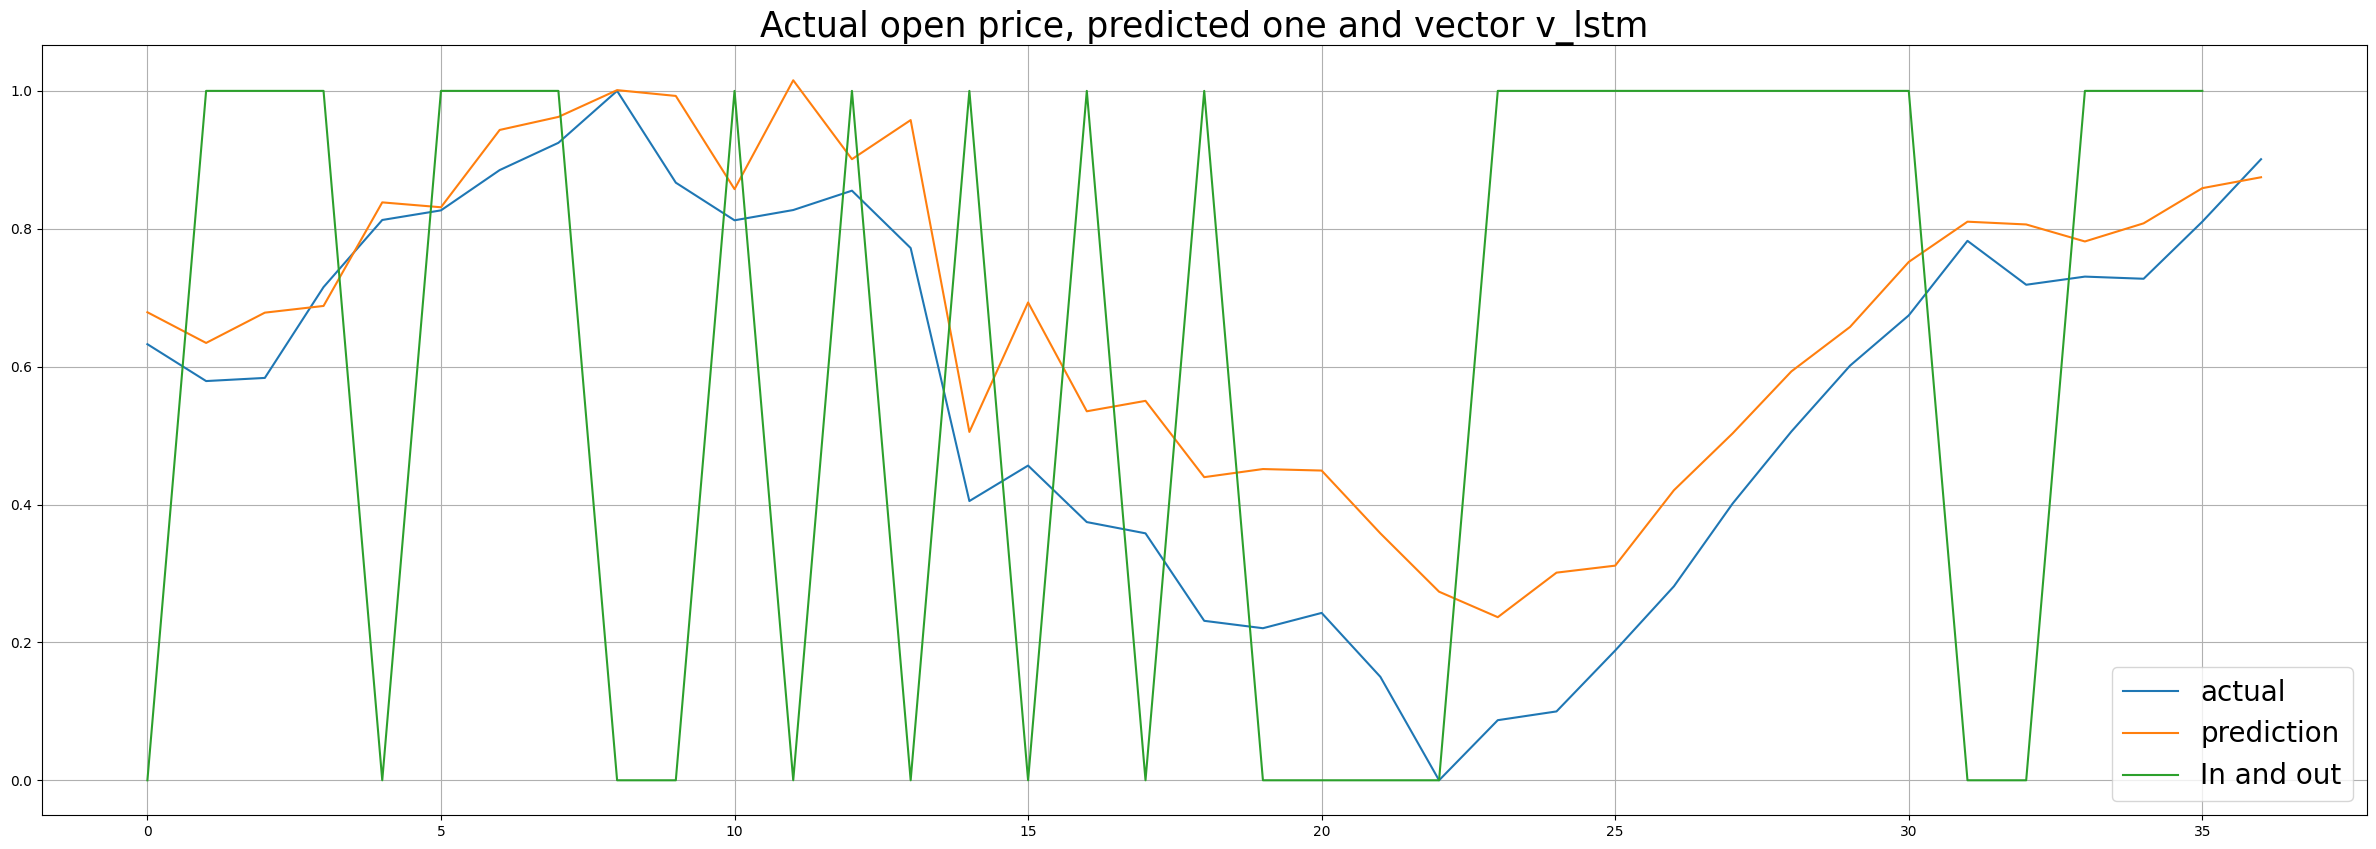

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

**The preceeding plot shows an interesting feature of the prediction of our model: it is quite good at predicting the sign of the first derivative of the index, but this is exactly what we need for our trading strategy!**

## Part 4: Compare the LSTM method with other methods

Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the months during which we are going to stay in the market.

In [ ]:
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"]

In [ ]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

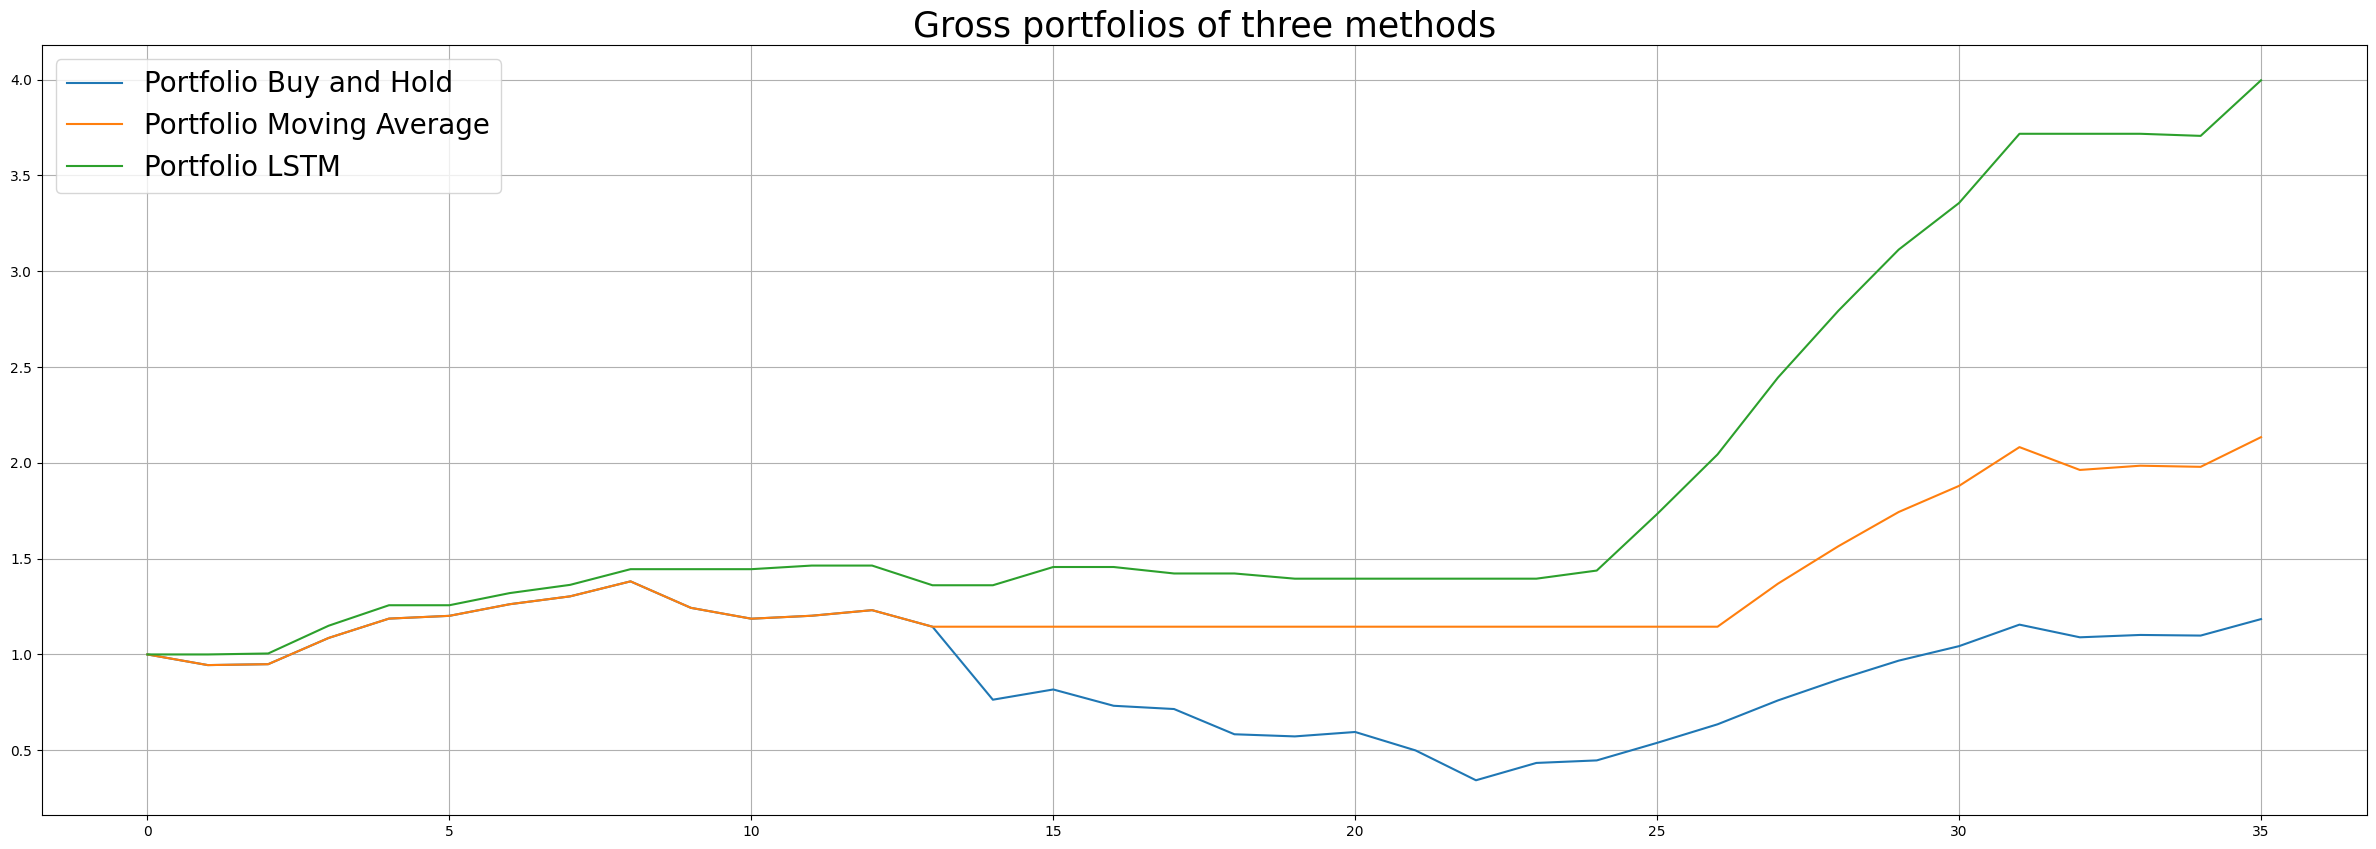

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [ ]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results0=pd.DataFrame({})
results1=pd.DataFrame({})
results2=pd.DataFrame({})
results3=pd.DataFrame({})

results0["Method"]=["Buy and hold","Moving average","LSTM"]
results1["Method"]=["Buy and hold","Moving average","LSTM"]
results2["Method"]=["Buy and hold","Moving average","LSTM"]
results3["Method"]=["Buy and hold","Moving average","LSTM"]

vs=[v_bh,v_ma,v_lstm]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results2["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results3["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)
print("\n")
print(results2)
print("\n")
print(results3)

Test period of 3.00 years, from 2021-01-04 to 2024-01-02 

           Method Total gross yield
0    Buy and hold           27.86 %
1  Moving average          130.36 %
2            LSTM          331.39 %


           Method Annual gross yield
0    Buy and hold             8.54 %
1  Moving average            32.07 %
2            LSTM            62.79 %


           Method Total net yield
0    Buy and hold         20.37 %
1  Moving average         92.87 %
2            LSTM        206.63 %


           Method Annual net yield
0    Buy and hold           6.38 %
1  Moving average          24.48 %
2            LSTM          45.28 %
